In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from astropy.time import Time
import astropy.units as u

from rms import Planet

In [109]:
times, spotted_lc, spotless_lc = np.loadtxt('ring.txt', unpack=True)

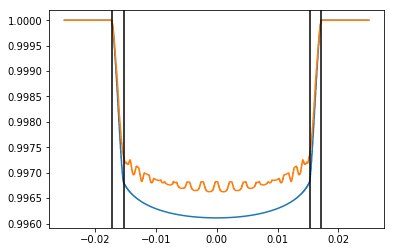

In [23]:
d = Planet(per=4.049959, inc=90, a=39.68, t0=0, 
           rp=(0.3566/100)**0.5, lam=0, ecc=0, w=90)

t14 = d.per/np.pi * np.arcsin( np.sqrt((1 + d.rp)**2 - d.b**2) / np.sin(np.radians(d.inc)) / d.a)
t23 = d.per/np.pi * np.arcsin( np.sqrt((1 - d.rp)**2 - d.b**2) / np.sin(np.radians(d.inc)) / d.a)

# plt.plot(times, spotted_lc - spotless_lc)
plt.plot(times, spotless_lc)

plt.plot(times, spotted_lc)

for i in [1, -1]:
    plt.axvline(i*t14/2, color='k')
    plt.axvline(i*t23/2, color='k')

In [56]:
from scipy.optimize import fmin_l_bfgs_b
from batman import TransitModel
from copy import deepcopy

d.limb_dark = 'quadratic'
d.u = [0.2, 0.1]
d.fp = 0

def transit_model(times, rprs, params):
    trial_params = deepcopy(params)
    params.rp = rprs
    m = TransitModel(params, times, supersample_factor=7, 
                     exp_time=times[1]-times[0])
    lc = m.light_curve(params)
    return lc

def chi2(p, times, y, params):
    rprs = p[0]
    return np.sum((transit_model(times, rprs, params) - y)**2)

In [78]:
initp =[d.rp]
d0 = fmin_l_bfgs_b(chi2, initp, approx_grad=True, 
                   args=(times, spotless_lc, d), 
                   bounds=[[0, 0.5]])[0][0]

In [92]:
mask_in_transit = (times > 0.5*(t14 + t23)/2) | (times < -0.5*(t14 + t23)/2)
# mask_in_transit = (times > t23/2) | (times < -t23/2)

bounds = [[0.5 * d.rp, 1.5 * d.rp]]
d1 = fmin_l_bfgs_b(chi2, initp, approx_grad=True, 
                   args=(times[mask_in_transit], spotless_lc[mask_in_transit], d), 
                   bounds=bounds)[0][0]

In [93]:
d2 = fmin_l_bfgs_b(chi2, initp, approx_grad=True, 
                   args=(times, spotted_lc, d), 
                   bounds=bounds)[0][0]

In [94]:
d3 = fmin_l_bfgs_b(chi2, initp, approx_grad=True, 
                   args=(times[mask_in_transit], spotted_lc[mask_in_transit], d), 
                   bounds=bounds)[0][0]

In [95]:
print("unspotted full LC \t = {0}\nunspotted only OOT \t = {1}\nspotted full LC "
      "\t = {2}\nspotted only OOT \t = {3}".format(d0, d1, d2, d3))

unspotted full LC 	 = 0.059722442725377724
unspotted only OOT 	 = 0.060050693857455595
spotted full LC 	 = 0.05500006086848168
spotted only OOT 	 = 0.056389741043236255


In [96]:
fractional_err = [(d0-d.rp)/d.rp, (d1-d.rp)/d.rp, (d2-d.rp)/d.rp, (d3-d.rp)/d.rp]
print("unspotted full LC \t = {0}\nunspotted only OOT \t = {1}\nspotted full LC "
      "\t = {2}\nspotted only OOT \t = {3}".format(*fractional_err))

unspotted full LC 	 = 0.00010798142267347136
unspotted only OOT 	 = 0.005604852650993289
spotted full LC 	 = -0.07897270534904278
spotted only OOT 	 = -0.05570121525296991


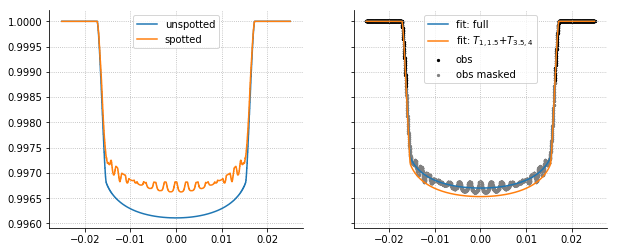

In [108]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4), sharey='row', sharex=True)

ax[0].plot(times, spotless_lc, label='unspotted')
ax[0].plot(times, spotted_lc, label='spotted')

ax[1].scatter(times[mask_in_transit], spotted_lc[mask_in_transit], label='obs', zorder=-10, 
                 s=5, color='k')
ax[1].scatter(times[~mask_in_transit], spotted_lc[~mask_in_transit], label='obs masked', zorder=-10, 
                 s=5, color='gray')
ax[1].plot(times, transit_model(times, d2, d), label='fit: full')
ax[1].plot(times, transit_model(times, d3, d), label='fit: $T_{1,1.5}$+$T_{3.5,4}$')

# ax[1, 1].scatter(range(2), fractional_err[2:])


for axis in fig.axes:
    axis.grid(ls=':')
    for s in ['right', 'top']:
        axis.spines[s].set_visible(False)
    axis.legend()
fig.savefig('ringofspots.pdf', bbox_inches='tight')

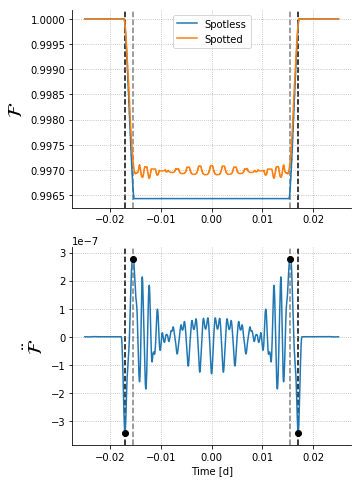

In [120]:
fig, ax = plt.subplots(2, 1, figsize=(5, 8))
ax[0].plot(times, spotless_lc, label='Spotless')
ax[0].plot(times, spotted_lc, label='Spotted')

from scipy.signal import savgol_filter

filtered = savgol_filter(spotted_lc, 101, 2, deriv=2)

n = len(times)//2
mins = [np.argmin(filtered[:n]), n + np.argmin(filtered[n:])]
maxes = [np.argmax(filtered[:n]), n + np.argmax(filtered[n:])]

ax[1].plot(times, filtered)

# t14 = -1*np.diff(times[mins])[0]
# t23 = -1*np.diff(times[maxes])[0]

ax[1].scatter(times[mins], filtered[mins], color='k', zorder=10)
ax[1].scatter(times[maxes], filtered[maxes], color='k', zorder=10)

for ts, c in zip([times[mins], times[maxes]], ['k', 'gray']):
    for t in ts:
        ax[0].axvline(t, ls='--', color=c, zorder=-10)
        ax[1].axvline(t, ls='--', color=c, zorder=-10)

for axis in fig.axes:
    axis.grid(ls=':')
    for s in ['right', 'top']:
        axis.spines[s].set_visible(False)
    axis.legend()
        
ax[0].set_ylabel('$\mathcal{F}$', fontsize=20)
ax[1].set_ylabel('$\ddot{\mathcal{F}}$', fontsize=20)
ax[1].set_xlabel('Time [d]')
fig.savefig('savgol.pdf', bbox_inches='tight')
plt.show()

In [113]:
one_plus_k = np.sqrt((np.sin(t14*np.pi/d.per) * np.sin(np.radians(d.inc)) * d.a)**2 + d.b**2)
one_minus_k = np.sqrt((np.sin(t23*np.pi/d.per) * np.sin(np.radians(d.inc)) * d.a)**2 + d.b**2)

In [114]:
k = (one_plus_k - one_minus_k)/2

print((k - d.rp)/d.rp)

-1.16198247407e-15
